In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data_utils
from torch import nn
import torch.optim as optim
import os
import copy
from pathvalidate import sanitize_filepath
import math
import pandas as pd
from timeit import default_timer as timer
import time
from datetime import datetime

In [2]:
def henon_map(xy, a=1.4, b=0.3): #xy is the array [x, y]
    x = xy[0]
    y = xy[1]
    x1 = 1 - 1.4*((x)**2) + 0.3*y
    y1 = x
    return np.array([x1, y1])

In [3]:
fn = henon_map
sv = np.array([0, 0.9])
params = {"a": 1.4, "b": 0.3}
embed_dim = 2
dim = 2

train_len = int(10**5)
n_test = 500
test_len = 100
discard = 10**5
batch_size = 64

loss_fn=nn.L1Loss()
opt=optim.Adam
epochs = 150
patience = 50
start_lr = 0.02
lr_decay_factor = 0.2

thresh = 0.01

n_runs = 5

In [4]:
system = {
    "name": str(fn.__name__),
    "fn": fn,
    "param": params,
    "dim": dim,
    "embed_dim": embed_dim,
    "sv": sv,
    "lyap": [0.41922, -1.62319],
    "ky_dim": 1.25827,
    "corr_dim": 1.220
}

In [5]:
def simulate_series(iters, map_fn, sv, dim, param_dict=None):
    assert len(sv) == dim
    series = np.empty((iters, dim))
    series[0] = sv
    for i in range(1, iters):
        if param_dict:
            series[i] = map_fn(series[i-1], **param_dict)
        else:
            series[i] = map_fn(series[i-1])
    return series

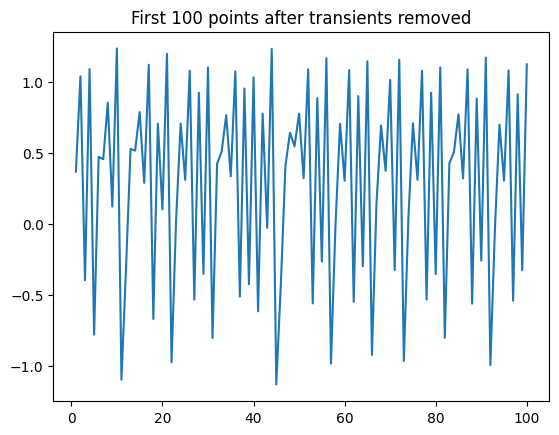

In [6]:
sim_len = train_len + (n_test*(embed_dim + test_len)) + discard
full_sim = simulate_series(iters=sim_len, map_fn=fn, sv=sv, dim=dim, param_dict=params)
full_1d = full_sim[:, 0]

x = np.arange(discard, discard + 100)
y = full_1d[min(x):max(x)+1]
xplot = x - discard + 1

plt.figure()
plt.plot(xplot, y)
plt.title("First 100 points after transients removed")
plt.show()
plt.close()

train_val_series = full_1d[discard:discard+train_len]
test_series = full_1d[discard+train_len:]
test_series_split = np.array(np.split(test_series, n_test))

assert train_len == len(train_val_series)
assert n_test*(embed_dim + test_len) == len(test_series)
assert train_val_series[0] == full_1d[discard]
assert train_val_series[-1] == full_1d[discard+train_len-1]
assert test_series[0] == full_1d[discard+train_len]

system["full_sim"] = full_sim
system["full_1d"] = full_1d
system["train_val_series"] = train_val_series
system["test_series"] = test_series
system["test_dts"] = test_series_split
system["acc_thresh"] = thresh*(np.max(full_1d) - np.min(full_1d))

In [7]:
def create_dataset(series, embed_dim):
    s_len = len(series)
    data_size = s_len-embed_dim
    inputs = np.empty((data_size, embed_dim, 1))
    outputs = np.empty((data_size, 1)) 
    
    #for univariate next step time series prediction
    #model input size (batch, embed_dim, 1)
    #model output size (batch, 1)
    
    for i in range(data_size):
        inputs[i] = series[i:i+embed_dim].reshape(embed_dim, 1)
        outputs[i] = series[i+embed_dim:i+embed_dim+1]
        
    print("Inputs = {}; Targets = {}".format(inputs.shape, outputs.shape))
        
    assert inputs.flatten()[0] == series[0]
    assert outputs.flatten()[-1] == series[-1]
    
    return data_utils.TensorDataset(torch.tensor(inputs), torch.tensor(outputs))

def create_dataloaders(series, embed_dim,
                       test_series=None, 
                       batch_size=64, train_split=0.8, val_split=0.2):
    
    assert train_split > 0
    
    if train_split + val_split != 1:
        print("Normalising train-val split...")
        train_split = train_split/(train_split+val_split)
        val_split = val_split/(train_split+val_split)
    print("Train:Validation = {}:{}".format(train_split, val_split))
    
    tv_dataset = create_dataset(series, embed_dim)
    
    tv_len = len(tv_dataset)
    train_len = int(train_split*tv_len)
    val_len = tv_len - train_len
    
    print("Number of training observations ({}%) = {}".format(train_split*100, train_len))
    print("Number of validation observations ({}%) = {}".format(val_split*100, val_len))
    
    train_tensor, val_tensor= torch.utils.data.random_split(tv_dataset,
                                                            [train_len, val_len])
    
    train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)
    
    if val_split:
        val_loader = data_utils.DataLoader(dataset = val_tensor, batch_size = batch_size, shuffle = False)
    else:
        print("No validation dataset created")
        val_loader = None
        
    test_loader = None
    if test_series is not None:
        test_dataset = create_dataset(test_series, embed_dim)
        print("Number of test observations = {}".format(len(test_dataset)))
        test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)
        
    loader_dict = {
        "batch_size" : batch_size,
        "train_loader" : train_loader,
        "val_loader" : val_loader,
        "test_loader" : test_loader
    }
    
    return loader_dict

In [8]:
class lstm(nn.Module):
    def __init__(self, lstm_hs=20, lstm_nl=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=lstm_hs,
                            num_layers=lstm_nl, batch_first=True)
        self.linear = nn.Linear(lstm_hs, 1)
        self.double()
    def forward(self, x):
        # LSMT input shape- (batch_size, sequence_length, input_size)
        x, _ = self.lstm(x)
        # LSMT output shape- (batch_size, sequence_length, hidden_size)
        x = x[:, -1, :] # take only last timestep
        # Linear input shape - (batch_size, hidden_size)
        x = self.linear(x) 
        # Linear output shape - (batch_size, 1)
        return x

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
    loss_val = loss.item()
    return loss_val

def calc_loss(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    n_obs = 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            b_size = len(X)
            pred = model(X)
            total_loss += loss_fn(pred, y).item() * b_size
            n_obs += b_size
    loss = total_loss/n_obs
    return loss

def train(epochs, model, train_loader, val_loader,
          model_name="", plot=True,
          patience=np.inf, loss_fn=nn.L1Loss(), opt=optim.Adam, start_lr = 0.1, lr_decay_factor = 0.2,
          if_save=False, save_path=os.getcwd()+ "/"):
    
    optimizer=opt(model.parameters(), lr=start_lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=lr_decay_factor)
    
    current_lr = start_lr
    lr_steps = []
    
    n = int(epochs/5) # determines printing of training progress
    x = np.arange(1, epochs+1, 1)
    train_loss = np.zeros(epochs)
    val_loss = np.zeros(epochs)
    model_savepath = sanitize_filepath(save_path + model_name + ".pth")
    
    best_val_loss = np.inf
    patience_count = 0
    t = 0

    print("Beginning Training {}".format(model_name))
    while t < epochs and patience_count <= patience:
        if (t+1) % n == 0:
            print("Training Epoch " + str(t+1) + " of " + str(epochs))
        train_loss[t] = train_loop(train_loader, model, loss_fn, optimizer)
        val_loss[t] = calc_loss(val_loader, model, loss_fn)
        if val_loss[t] < best_val_loss:
            best_val_loss = val_loss[t]
            best_model = copy.deepcopy(model)
            patience_count = 0
        else:
            patience_count += 1
        scheduler.step(val_loss[t])
        new_lr = scheduler.optimizer.param_groups[0]['lr']
        if new_lr != current_lr:
            print("Learning rate change {} -> {} (Epoch {})".format(current_lr, new_lr, t+1))
            current_lr = new_lr
            lr_steps.append(t+1)
        t += 1
          
    last_epoch = t
    if patience_count >= patience:
        print("Model training terminated early at epoch {}".format(last_epoch))
        
    x = x[0:last_epoch]
    train_loss = train_loss[0:last_epoch]
    val_loss = val_loss[0:last_epoch]
        
    if plot:
        plt.figure()
        plt.plot(x,train_loss, label="Train Loss")
        plt.plot(x,val_loss, label="Validation Loss")
        for step in lr_steps:
            plt.axvline(x=step, color='black', ls='--')
        plt.legend()
        if model_name == "":
            plt.title("Loss During Training")
        else:
            plt.title("Loss During Training - " + model_name)
        plt.xlabel("Epochs")
        plt.show()
        plt.close()

    final_val_loss = calc_loss(val_loader, best_model, loss_fn)
    if round(final_val_loss, 6) != round(best_val_loss, 6):
        print("Final loss = {}".format(final_val_loss))
        print("Best loss = {}".format(best_val_loss))
    assert round(final_val_loss, 6) == round(best_val_loss, 6)
    print(model_name + " : Final model loss = " + str(round(final_val_loss, 6)))
    if if_save:
        print("Model saved to: {}".format(model_savepath))
        torch.save(best_model.state_dict(), model_savepath)
    return best_model

In [10]:
def pred_test_dts(test_dts, model, embed_dim):
    n_series = test_dts.shape[0]
    test_len = test_dts.shape[1]
    test_pred = np.zeros(test_dts.shape)
    test_pred[:, 0:embed_dim] = test_dts[:, 0:embed_dim]
    
    for i in range(embed_dim, test_len):
        inp = torch.tensor(test_pred[:, i-embed_dim:i], dtype=torch.double)
        inp = torch.reshape(inp, (n_series, embed_dim, 1))        
        test_pred[:, i] = np.reshape(model(inp).detach().numpy(), (n_series,))
       
    return test_pred

def eval_predictions(test_dts, pred_dts, embed_dim, title='', acc_thresh=0.01, z=1.96):
    print("Prediction horizon calculation for {}".format(title))
    print("Accuracy Threshold = {}".format(acc_thresh))
    
    n_tests = test_dts.shape[0]
    test_len = test_dts.shape[1]
    
    print("{} Series of {} timesteps ({} predictions) each".format(n_tests, test_len, test_len-embed_dim))
    
    diff_all = np.abs(test_dts - pred_dts)
    diff = diff_all[:, embed_dim:]
    
#     for i in range(n_tests):
#         for j in range(test_len-embed_dim):
#             assert diff_all[i, j+embed_dim] == diff[i,j]
            
    avg_diff = np.mean(diff, axis=0)
    max_diff = np.max(diff, axis=0)
    min_diff = np.min(diff, axis=0)
    lower_quart = np.percentile(diff, 25, axis=0)
    upper_quart = np.percentile(diff, 75, axis=0)
    a_diff = avg_diff
    max_diff = max_diff
    min_diff = min_diff
    low_diff = lower_quart
    upp_diff = upper_quart
    iters = np.arange(1, test_len-embed_dim+1)
    
    plt.figure()
    plt.title(title)
    plt.plot(iters, a_diff, label="Mean", color='red')
    plt.plot(iters, max_diff, label="Max", color='blue')
    plt.plot(iters, min_diff, label="Min", color='green')
    plt.plot(iters, low_diff, label="25th Percentile", ls='--', color='black')
    plt.plot(iters, upp_diff, label="75th Percentile", ls='--', color='black')
    plt.xlabel("Iterations Forward")
    plt.ylabel("Average Error")
    plt.legend()
    plt.show()
    plt.close()
    
    n_acc_iters = np.empty(n_tests)
    
    for i in range(n_tests):
        if max(diff[i]) <= acc_thresh:
            print("Accuracy threshold: {}".format(acc_thresh))
            print("Max prediction error: {}".format(max(diff[i])))
            raise Exception("Testing series too short, entire series predicted accurately")
        
        n_acc_iters[i] = next(j for j,v in enumerate(diff[i]) if diff[i,j] > acc_thresh)
        
        if n_acc_iters[i] != 0:
            assert diff[i, int(n_acc_iters[i]-1)] <= acc_thresh
        assert diff[i, int(n_acc_iters[i])] > acc_thresh
    
    n_acc_avg = next(j for j,v in enumerate(a_diff) if a_diff[j] > acc_thresh)
    
    if n_acc_avg != 0:
        assert a_diff[int(n_acc_avg) - 1] <= acc_thresh
    assert a_diff[int(n_acc_avg)] > acc_thresh
        
    mean_iters = np.mean(n_acc_iters)
    upper_quart = np.percentile(n_acc_iters, 75)
    lower_quart = np.percentile(n_acc_iters, 25)
    
    plt.figure()
    plt.title(title)
    
    nbins = max(1, int(max(n_acc_iters) - min(n_acc_iters)))
    
    d = np.diff(np.unique(n_acc_iters)).min()
    left_of_first_bin = n_acc_iters.min() - float(d)/2
    right_of_last_bin = n_acc_iters.max() + float(d)/2
    
    hist = plt.hist(n_acc_iters, 
                    np.arange(-0.5, n_acc_iters.max() + 1), 
                    edgecolor = "black")
    plt.plot([mean_iters, mean_iters], [0,n_tests], color='red',
             label="Mean of number of accurate iters: " + str(round(mean_iters, 4)))
    plt.plot([n_acc_avg, n_acc_avg], [0,n_tests], color='green',
             label="Number of iters for mean error: " + str(round(n_acc_avg, 4)))
    plt.plot([upper_quart, upper_quart], [0,n_tests], color='black', ls='--',
             label="Upper Quartile: " + str(round(upper_quart, 4)))
    plt.plot([lower_quart, lower_quart], [0,n_tests], color='black', ls='--',
             label="Lower Quartile: " + str(round(lower_quart, 4)))
    plt.xlabel("Iterations Forward below " + str(acc_thresh) + " error")
    plt.ylim(0, 1.2*np.max(hist[0]))
    plt.legend()
    plt.show()
    plt.close()
    
    sd = np.std(n_acc_iters)
    error = z*(sd/np.sqrt(n_tests))
    
    print("Number of accurate iters: Mean = " + str(mean_iters) + "; S.D. = " + str(round(sd, 4)))
    
    return (mean_iters, error)

Train:Validation = 0.8:0.2
Inputs = (99998, 2, 1); Targets = (99998, 1)
Number of training observations (80.0%) = 79998
Number of validation observations (20.0%) = 20000
Inputs = (50998, 2, 1); Targets = (50998, 1)
Number of test observations = 50998
Beginning Training LSTM_1
Learning rate change 0.02 -> 0.004 (Epoch 14)
Training Epoch 30 of 150
Learning rate change 0.004 -> 0.0008 (Epoch 31)
Training Epoch 60 of 150
Learning rate change 0.0008 -> 0.00016 (Epoch 63)
Learning rate change 0.00016 -> 3.2000000000000005e-05 (Epoch 88)
Training Epoch 90 of 150
Learning rate change 3.2000000000000005e-05 -> 6.400000000000001e-06 (Epoch 100)
Training Epoch 120 of 150
Training Epoch 150 of 150


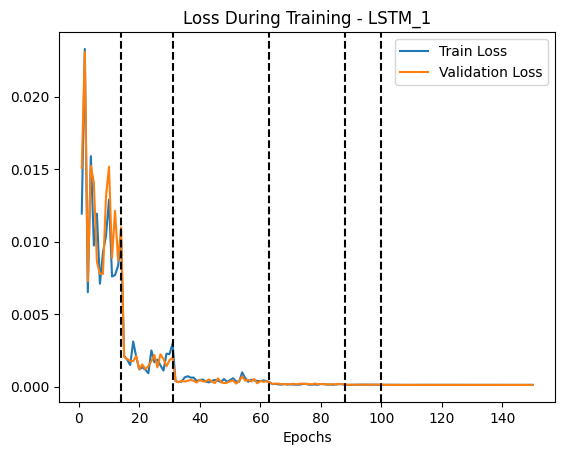

LSTM_1 : Final model loss = 0.000122
Prediction horizon calculation for LSTM_1
Accuracy Threshold = 0.025576334880781353
500 Series of 102 timesteps (100 predictions) each


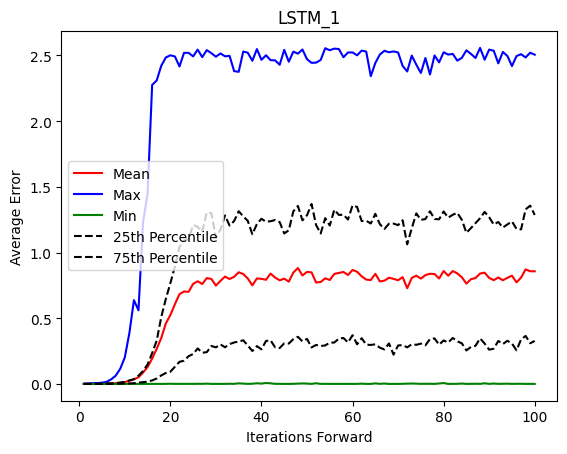

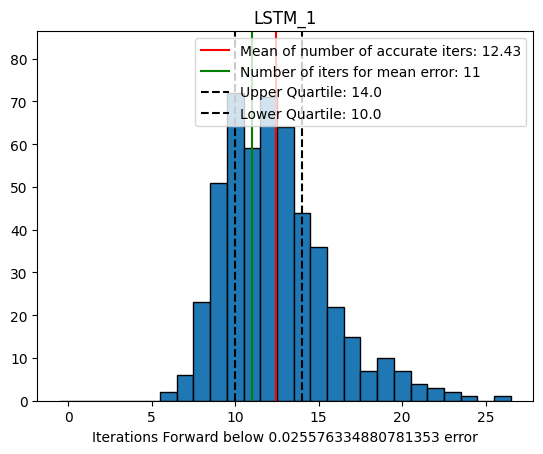

Number of accurate iters: Mean = 12.43; S.D. = 3.1593
Beginning Training LSTM_2
Learning rate change 0.02 -> 0.004 (Epoch 14)
Training Epoch 30 of 150
Learning rate change 0.004 -> 0.0008 (Epoch 31)
Training Epoch 60 of 150
Learning rate change 0.0008 -> 0.00016 (Epoch 63)
Learning rate change 0.00016 -> 3.2000000000000005e-05 (Epoch 88)
Training Epoch 90 of 150
Learning rate change 3.2000000000000005e-05 -> 6.400000000000001e-06 (Epoch 100)
Training Epoch 120 of 150
Training Epoch 150 of 150


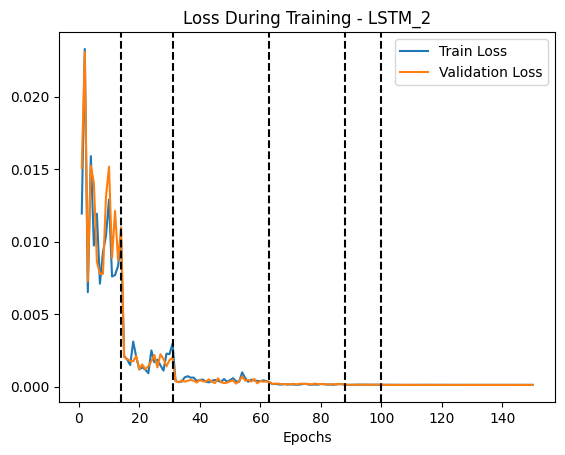

LSTM_2 : Final model loss = 0.000122
Prediction horizon calculation for LSTM_2
Accuracy Threshold = 0.025576334880781353
500 Series of 102 timesteps (100 predictions) each


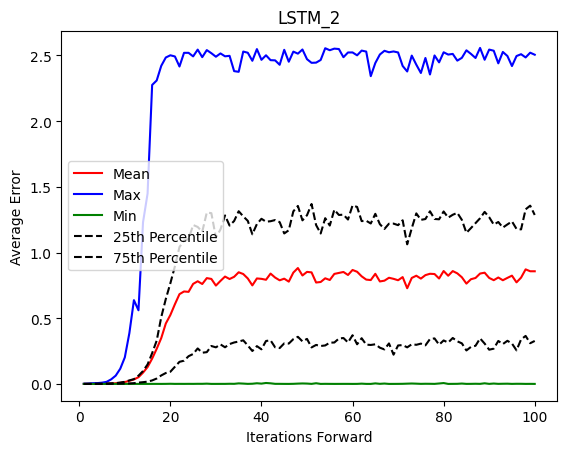

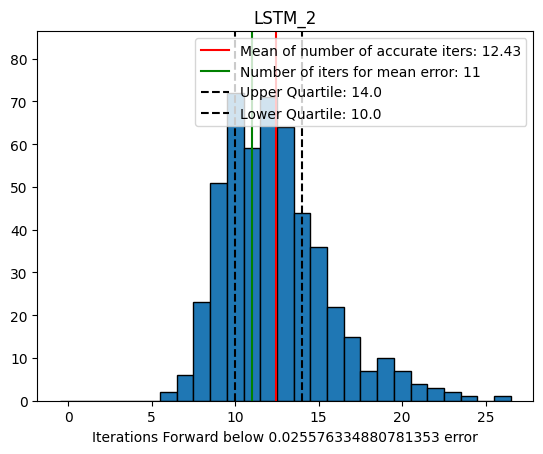

Number of accurate iters: Mean = 12.43; S.D. = 3.1593
Beginning Training LSTM_3
Learning rate change 0.02 -> 0.004 (Epoch 14)
Training Epoch 30 of 150
Learning rate change 0.004 -> 0.0008 (Epoch 31)
Training Epoch 60 of 150
Learning rate change 0.0008 -> 0.00016 (Epoch 63)
Learning rate change 0.00016 -> 3.2000000000000005e-05 (Epoch 88)
Training Epoch 90 of 150
Learning rate change 3.2000000000000005e-05 -> 6.400000000000001e-06 (Epoch 100)
Training Epoch 120 of 150
Training Epoch 150 of 150


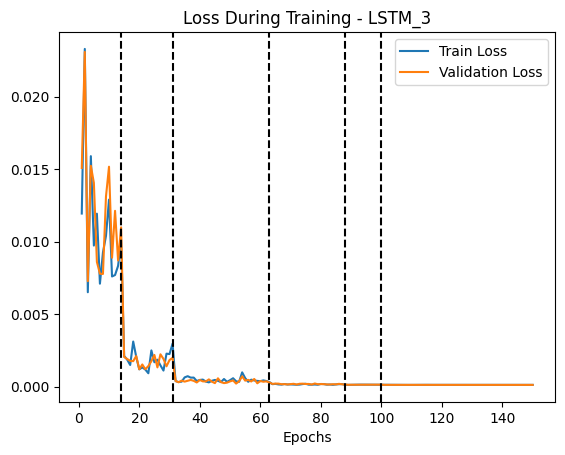

LSTM_3 : Final model loss = 0.000122
Prediction horizon calculation for LSTM_3
Accuracy Threshold = 0.025576334880781353
500 Series of 102 timesteps (100 predictions) each


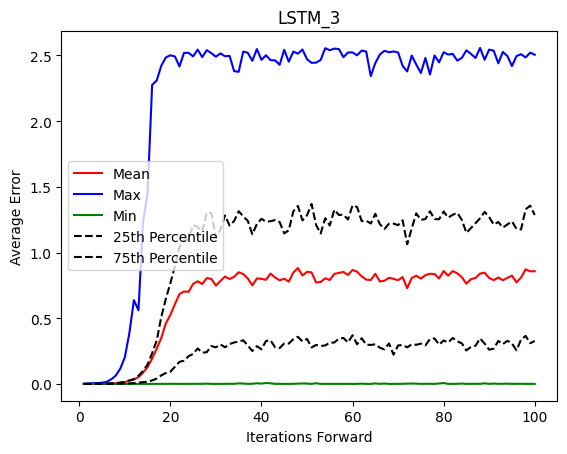

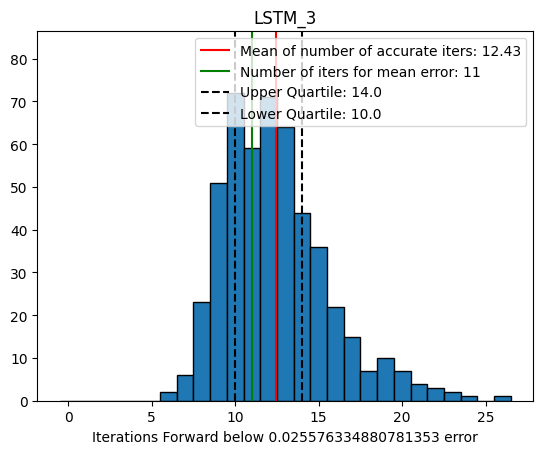

Number of accurate iters: Mean = 12.43; S.D. = 3.1593
Beginning Training LSTM_4
Learning rate change 0.02 -> 0.004 (Epoch 14)
Training Epoch 30 of 150
Learning rate change 0.004 -> 0.0008 (Epoch 31)
Training Epoch 60 of 150
Learning rate change 0.0008 -> 0.00016 (Epoch 63)
Learning rate change 0.00016 -> 3.2000000000000005e-05 (Epoch 88)
Training Epoch 90 of 150
Learning rate change 3.2000000000000005e-05 -> 6.400000000000001e-06 (Epoch 100)
Training Epoch 120 of 150
Training Epoch 150 of 150


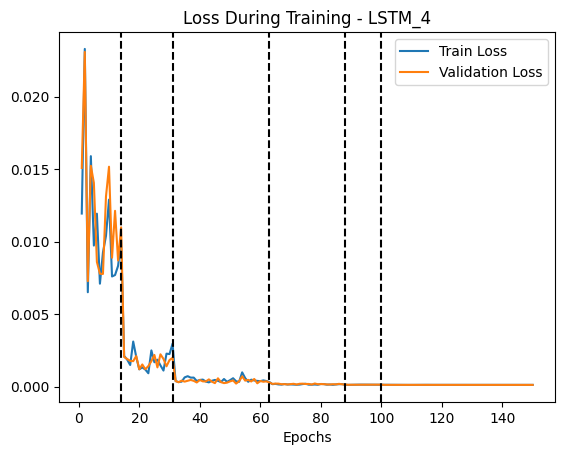

LSTM_4 : Final model loss = 0.000122
Prediction horizon calculation for LSTM_4
Accuracy Threshold = 0.025576334880781353
500 Series of 102 timesteps (100 predictions) each


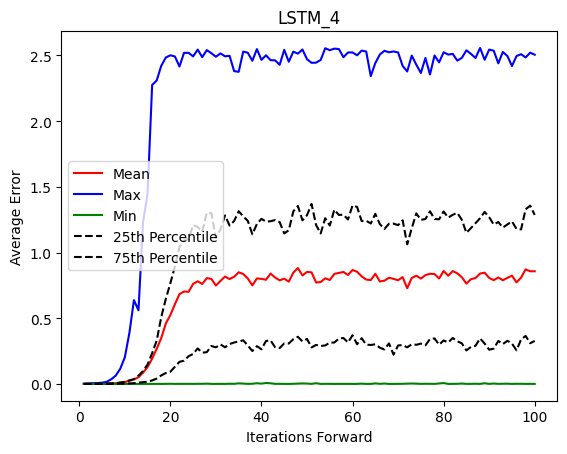

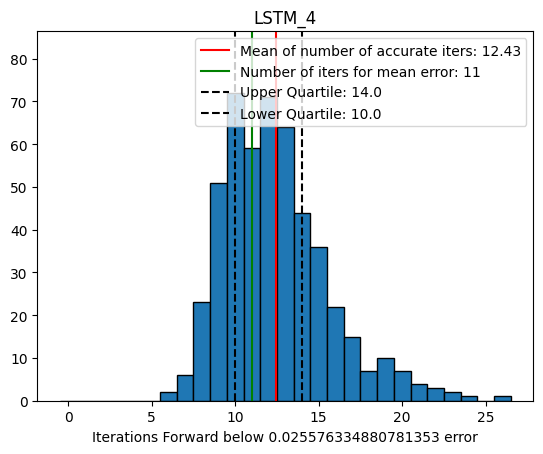

Number of accurate iters: Mean = 12.43; S.D. = 3.1593
Beginning Training LSTM_5
Learning rate change 0.02 -> 0.004 (Epoch 14)
Training Epoch 30 of 150
Learning rate change 0.004 -> 0.0008 (Epoch 31)
Training Epoch 60 of 150
Learning rate change 0.0008 -> 0.00016 (Epoch 63)
Learning rate change 0.00016 -> 3.2000000000000005e-05 (Epoch 88)
Training Epoch 90 of 150
Learning rate change 3.2000000000000005e-05 -> 6.400000000000001e-06 (Epoch 100)
Training Epoch 120 of 150
Training Epoch 150 of 150


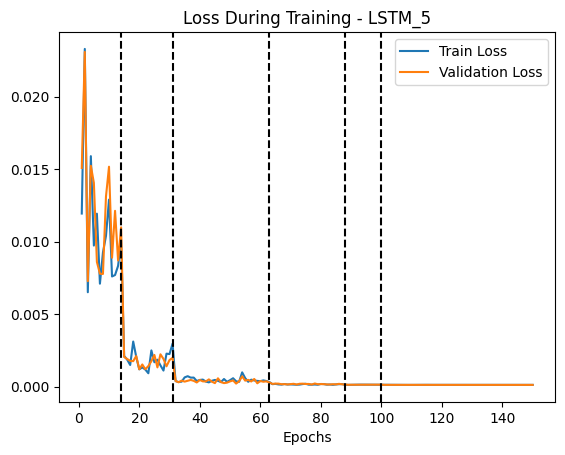

LSTM_5 : Final model loss = 0.000122
Prediction horizon calculation for LSTM_5
Accuracy Threshold = 0.025576334880781353
500 Series of 102 timesteps (100 predictions) each


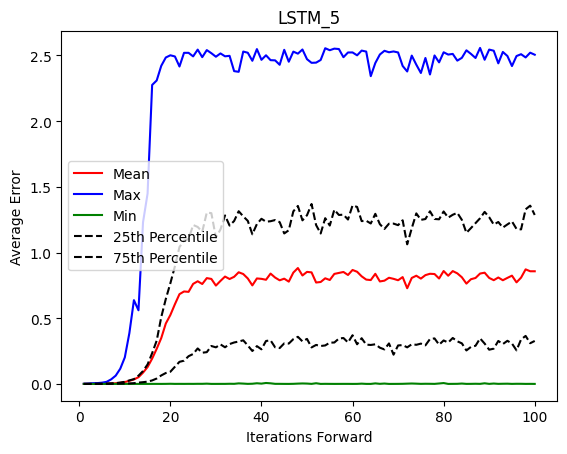

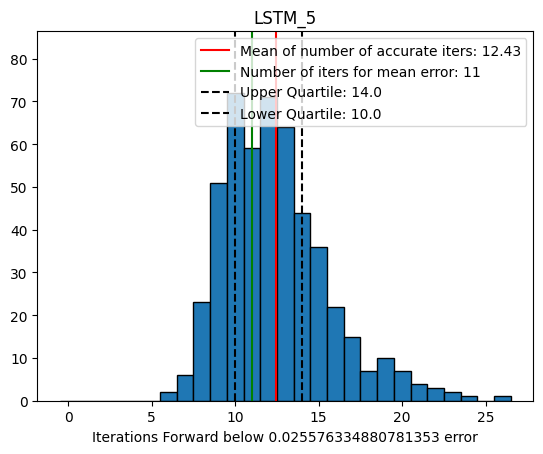

Number of accurate iters: Mean = 12.43; S.D. = 3.1593


In [11]:
models = []

base_model = lstm()

loader_dict = create_dataloaders(series=system["train_val_series"],
                                    embed_dim=system["embed_dim"], 
                                    test_series=system["test_series"], 
                                    batch_size=batch_size, train_split=0.8, val_split=0.2)

for i in range(n_runs):
    torch.manual_seed(i+1)
    mod_dict = {
        "name": "lstm_henon",
        "id": i+1
    }
    
    model = None
    trained_model = None
    
    
    model = copy.deepcopy(base_model)
    start = timer()
    
    trained_model = train(epochs=epochs, model=model, 
                              train_loader=loader_dict["train_loader"], 
                              val_loader=loader_dict["val_loader"],
                              model_name="LSTM_{}".format(i+1), plot=True,
                              patience=patience, loss_fn=loss_fn,
                              opt=opt, start_lr = start_lr, lr_decay_factor = lr_decay_factor,
                              if_save=False, save_path=os.getcwd()+ "/")
    
    end = timer()
    mod_dict["training_time"] = end-start
    mod_dict["testing_loss"] = calc_loss(loader_dict["test_loader"], trained_model, loss_fn)
    test_pred = pred_test_dts(test_dts=system["test_dts"],
                              model=trained_model,
                              embed_dim=system["embed_dim"])
    eval_results = eval_predictions(test_dts=system["test_dts"],
                                    pred_dts=test_pred,
                                    embed_dim=embed_dim, title="LSTM_{}".format(i+1),
                                    acc_thresh=system["acc_thresh"], z=1.96)
    mod_dict["pred_horizon"] = eval_results[0]
    mod_dict["pred_uncert"] = eval_results[1]
    #mod_dict["series_length"] = len(system["train_val_series"])
    models.append(mod_dict)

In [12]:
df = pd.DataFrame(models)
df.head()

,name,id,training_time,testing_loss,pred_horizon,pred_uncert
0,lstm_henon,1,381.142787,0.000122,12.43,0.276924
1,lstm_henon,2,673.133117,0.000122,12.43,0.276924
2,lstm_henon,3,718.106925,0.000122,12.43,0.276924
3,lstm_henon,4,724.412666,0.000122,12.43,0.276924
4,lstm_henon,5,724.006669,0.000122,12.43,0.276924


In [13]:
path = sanitize_filepath("C:/Users/B00955739/Documents/variance_sameinit_noshuffle__"
                         + str(time.strftime("%d_%m_%Y__%H_%M_%S")))
path = path + ".csv"
print("Saving to {}".format(path))
df.to_csv(path)

Saving to C:/Users/B00955739/Documents/variance_sameinit_noshuffle__05_07_2024__18_35_19.csv
